# Chapter 3: Regridding

**Prerequisite**: Minimal xarray knowledge in [Chapter01_NetCDF_xarray.ipynb](./Chapter01_NetCDF_xarray.ipynb).

One of the most difficult thing in Earth science data processing is regridding. But it is no longer difficult with the [xESMF](http://xesmf.readthedocs.io) package I wrote.


**Windows users** [need some additional tricks](http://xesmf.readthedocs.io/en/latest/installation.html#notes-for-windows-users) in order to use xESMF on your local computer. Besides the Binder cloud, using a Linux server might be the easiest way. If you don't have a Linux server at all, try my [GEOS-Chem on cloud project](http://cloud-gc.readthedocs.io/) 

In [1]:
# those modules are almost always imported when working with model data
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr 
from gamap_colormap import WhGrYlRd

import xesmf as xe # the regridding tool !

# The first example

We use the restart file as in Chapter 1. A common need is to regrid a global low-resolution restart file to a regional high-resolution grid.

In [2]:
ds = xr.open_dataset("initial_GEOSChem_rst.4x5_tropchem.nc")

We first focus on a single variable O3:

In [3]:
ds['TRC_O3']

<xarray.DataArray 'TRC_O3' (time: 1, lev: 47, lat: 46, lon: 72)>
[155664 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2005-07-01
  * lev      (lev) float32 0.9924996 0.9774562 ... 0.00012699311 2.7634127e-05
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
Attributes:
    long_name:  O3 tracer
    units:      mol/mol

Let's regrid it to the [0.5 x 0.625 NA nested grid](http://wiki.seas.harvard.edu/geos-chem/index.php/GEOS-Chem_horizontal_grids#0.5_x_0.625_NA_nested_grid). First compute the target grid.

In [4]:
nested_grid = {'lon': np.linspace(-140, -40, 161),
               'lat': np.linspace(10, 70, 121)
              }
nested_grid

{'lon': array([-140.   , -139.375, -138.75 , -138.125, -137.5  , -136.875,
        -136.25 , -135.625, -135.   , -134.375, -133.75 , -133.125,
        -132.5  , -131.875, -131.25 , -130.625, -130.   , -129.375,
        -128.75 , -128.125, -127.5  , -126.875, -126.25 , -125.625,
        -125.   , -124.375, -123.75 , -123.125, -122.5  , -121.875,
        -121.25 , -120.625, -120.   , -119.375, -118.75 , -118.125,
        -117.5  , -116.875, -116.25 , -115.625, -115.   , -114.375,
        -113.75 , -113.125, -112.5  , -111.875, -111.25 , -110.625,
        -110.   , -109.375, -108.75 , -108.125, -107.5  , -106.875,
        -106.25 , -105.625, -105.   , -104.375, -103.75 , -103.125,
        -102.5  , -101.875, -101.25 , -100.625, -100.   ,  -99.375,
         -98.75 ,  -98.125,  -97.5  ,  -96.875,  -96.25 ,  -95.625,
         -95.   ,  -94.375,  -93.75 ,  -93.125,  -92.5  ,  -91.875,
         -91.25 ,  -90.625,  -90.   ,  -89.375,  -88.75 ,  -88.125,
         -87.5  ,  -86.875,  -86.25 ,  -8

xESMF contains [multiple regridding algorithms](http://xesmf.readthedocs.io/en/latest/Compare_algorithms.html). Try the simplest bilinear scheme first.

In [5]:
regridder_bilinear = xe.Regridder(ds, nested_grid, method='bilinear')

Create weight file: bilinear_46x72_121x161.nc


Apply this "regridder" our Ozone field:

In [6]:
dr_nested = regridder_bilinear(ds['TRC_O3'])
dr_nested

<xarray.DataArray 'TRC_O3' (time: 1, lev: 47, lat: 121, lon: 161)>
array([[[[1.107574e-08, ..., 1.996190e-08],
         ...,
         [1.342321e-08, ..., 2.378063e-08]],

        ...,

        [[9.013729e-08, ..., 8.819149e-08],
         ...,
         [7.028192e-08, ..., 6.966938e-08]]]])
Coordinates:
  * time     (time) datetime64[ns] 2005-07-01
  * lev      (lev) float32 0.9924996 0.9774562 ... 0.00012699311 2.7634127e-05
  * lon      (lon) float64 -140.0 -139.4 -138.8 -138.1 ... -41.25 -40.62 -40.0
  * lat      (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 68.0 68.5 69.0 69.5 70.0
Attributes:
    regrid_method:  bilinear

xESMF preserves xarray metadata (coordinate names, etc...), so you can use xarray's quick plotting method.

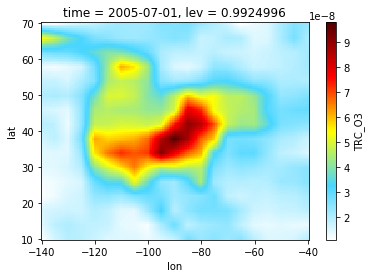

In [7]:
dr_nested.isel(time=0, lev=0).plot(cmap=WhGrYlRd)

Compare it against the original global field:

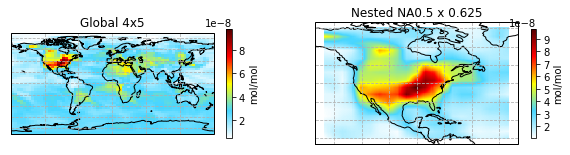

In [8]:
fig, axes = plt.subplots(1, 2, figsize=[10, 4], subplot_kw={'projection': ccrs.PlateCarree()})

# Plot global data on the left side
ds['TRC_O3'].isel(time=0, lev=0).plot(ax=axes[0], cmap=WhGrYlRd, 
                                      cbar_kwargs={'shrink': 0.5, 'label': 'mol/mol'})
axes[0].set_title('Global 4x5')


# Plot nested on on the right side
dr_nested.isel(time=0, lev=0).plot(ax=axes[1], cmap=WhGrYlRd, 
                                   cbar_kwargs={'shrink': 0.5, 'label': 'mol/mol'})
axes[1].set_title('Nested NA0.5 x 0.625')

for ax in axes:
    ax.coastlines()
    ax.gridlines(linestyle='--')

# Conservative regridding

`bilinear` is not the best algorithm for regridding tracer field since it does not conserve total mass. A better algorithm is `conservative`.

To use `conservative` regridding, you need to specify the cell boundaries, since the boundary information is needed for calculating overlapping areas (thus ensures total mass conservation). Boundary positions cannot be automatically computed from cell center positions, due to many special cases (e.g. GEOS-Chem's half-polar cells, GCHP's cubed-sphere grids), so it is safer to re-calculate it manually! 

In [9]:
nested_grid_with_bounds = {'lon': np.linspace(-140, -40, 161),
                           'lat': np.linspace(10, 70, 121),
                           'lon_b': np.linspace(-140-0.625/2, -40+0.625/2, 162),
                           'lat_b': np.linspace(10-0.5/2, 70+0.5/2, 122),
                          }

global_grid_with_bounds = {'lon': ds['lon'].values,
                           'lat': ds['lat'].values,
                           'lon_b': np.linspace(-180-5/2, 175+5/2, 73),
                           'lat_b': np.linspace(-92, 92, 47).clip(-90, 90), # fix half-polar cells
                          }

In [10]:
# The clip() function prevents the polar cell from exceeding -90/90
global_grid_with_bounds['lat_b']

array([-90., -88., -84., -80., -76., -72., -68., -64., -60., -56., -52.,
       -48., -44., -40., -36., -32., -28., -24., -20., -16., -12.,  -8.,
        -4.,   0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,
        40.,  44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,
        84.,  88.,  90.])

Make a new regridder with `conservative` option and apply it to our data.

In [11]:
regridder_conserve = xe.Regridder(global_grid_with_bounds, nested_grid_with_bounds, method='conservative')

Create weight file: conservative_46x72_121x161.nc


In [12]:
dr_conserve = regridder_conserve(ds['TRC_O3'])
dr_conserve

<xarray.DataArray 'TRC_O3' (time: 1, lev: 47, lat: 121, lon: 161)>
array([[[[1.107574e-08, ..., 1.996190e-08],
         ...,
         [1.342321e-08, ..., 2.378063e-08]],

        ...,

        [[9.013729e-08, ..., 8.819149e-08],
         ...,
         [7.028192e-08, ..., 6.966938e-08]]]])
Coordinates:
  * time     (time) datetime64[ns] 2005-07-01
  * lev      (lev) float32 0.9924996 0.9774562 ... 0.00012699311 2.7634127e-05
  * lon      (lon) float64 -140.0 -139.4 -138.8 -138.1 ... -41.25 -40.62 -40.0
  * lat      (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 68.0 68.5 69.0 69.5 70.0
Attributes:
    regrid_method:  conservative

Comparing two algorithms:

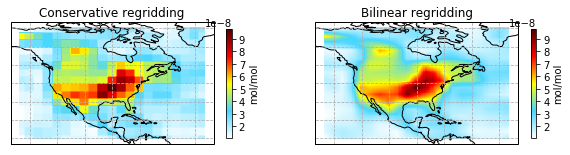

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[10, 4], subplot_kw={'projection': ccrs.PlateCarree()})

# Plot global data on the left side
dr_conserve.isel(time=0, lev=0).plot(ax=axes[0], cmap=WhGrYlRd, 
                                      cbar_kwargs={'shrink': 0.5, 'label': 'mol/mol'})
axes[0].set_title('Conservative regridding')


# Plot nested on on the right side
dr_nested.isel(time=0, lev=0).plot(ax=axes[1], cmap=WhGrYlRd, 
                                   cbar_kwargs={'shrink': 0.5, 'label': 'mol/mol'})
axes[1].set_title('Bilinear regridding')

for ax in axes:
    ax.coastlines()
    ax.gridlines(linestyle='--')

You can see that conservative regridding preserves the coarse-grid structure, while the bilinear algorithm produces smooth results.

To more rigorously conserve mass, you would scale the mixing ratio field by air density before regridding, and then scale the regridding result back to mixing ratio. But let's stick to this simple method for now.

# Regrid Dataset with multiple variables

## Use native functionality (require xesmf>=0.2.0)

In [14]:
xe.__version__

'0.2.0'

xESMF knows to automatically loop over all variables inside a `xarray.Dataset`.

In [15]:
%time ds_result = regridder_conserve(ds)

using dimensions ('lat', 'lon') from data variable TRC_NO as the horizontal dimensions for this dataset.
CPU times: user 302 ms, sys: 421 ms, total: 722 ms
Wall time: 632 ms


Notice how fast it is! On my Mac, it takes less than a second to regrid the entire file. This is orders of magnitude faster than IDL/gamap, and can save a lot of research time. In the past, I could spend an entire morning just to create a nested restart file (by regridding), because IDL was too slow.

In [16]:
ds_result  # it contains all variables, on the nested grid.

<xarray.Dataset>
Dimensions:     (lat: 121, lev: 47, lon: 161, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2005-07-01
  * lev         (lev) float32 0.9924996 0.9774562 ... 2.7634127e-05
  * lon         (lon) float64 -140.0 -139.4 -138.8 ... -41.25 -40.62 -40.0
  * lat         (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 68.5 69.0 69.5 70.0
Data variables:
    TRC_NO      (time, lev, lat, lon) float64 1.37e-12 1.37e-12 ... 1.619e-09
    TRC_O3      (time, lev, lat, lon) float64 1.108e-08 1.108e-08 ... 6.967e-08
    TRC_PAN     (time, lev, lat, lon) float64 7.389e-14 7.389e-14 ... 1.386e-18
    TRC_CO      (time, lev, lat, lon) float64 7.082e-08 7.082e-08 ... 1.909e-08
    TRC_ALK4    (time, lev, lat, lon) float64 7.891e-12 7.891e-12 ... 4.703e-23
    TRC_ISOP    (time, lev, lat, lon) float64 1e-30 1e-30 1e-30 ... 1e-30 1e-30
    TRC_HNO3    (time, lev, lat, lon) float64 9.969e-12 9.969e-12 ... 2.796e-22
    TRC_H2O2    (time, lev, lat, lon) float64 6.864e-10 6.864e-10 ... 

## Manually loop over all variables

Alternatively, you can loop over all variables in an xarray `Dataset`.

In [17]:
for varname, dr in ds.data_vars.items():
    # You have access to each DataArray `dr` inside the for loop,
    # but here we just print the variable name and go to the next variable
    print(varname, end=', ')

TRC_NO, TRC_O3, TRC_PAN, TRC_CO, TRC_ALK4, TRC_ISOP, TRC_HNO3, TRC_H2O2, TRC_ACET, TRC_MEK, TRC_ALD2, TRC_RCHO, TRC_MVK, TRC_MACR, TRC_PMN, TRC_PPN, TRC_R4N2, TRC_PRPE, TRC_C3H8, TRC_CH2O, TRC_C2H6, TRC_N2O5, TRC_HNO4, TRC_MP, TRC_DMS, TRC_SO2, TRC_SO4, TRC_SO4s, TRC_MSA, TRC_NH3, TRC_NH4, TRC_NIT, TRC_NITs, TRC_BCPI, TRC_OCPI, TRC_BCPO, TRC_OCPO, TRC_DST1, TRC_DST2, TRC_DST3, TRC_DST4, TRC_SALA, TRC_SALC, TRC_Br2, TRC_Br, TRC_BrO, TRC_HOBr, TRC_HBr, TRC_BrNO2, TRC_BrNO3, TRC_CHBr3, TRC_CH2Br2, TRC_CH3Br, TRC_MPN, TRC_ISOPN, TRC_MOBA, TRC_PROPNN, TRC_HAC, TRC_GLYC, TRC_MMN, TRC_RIP, TRC_IEPOX, TRC_MAP, TRC_NO2, TRC_NO3, TRC_HNO2, 

We can regrid each variable one by one and merge them together.

In [18]:
%%time
result_list = [] # an emtpy list to hold regridding result

for varname, dr in ds.data_vars.items():
    dr_temp = regridder_conserve(dr)  # temporary variable for the current tracer
    result_list.append(dr_temp)  # add the current result to the list
    
ds_result_manual = xr.merge(result_list)  # merge a list of DataArray to a single Dataset

CPU times: user 378 ms, sys: 316 ms, total: 694 ms
Wall time: 688 ms


In [19]:
# compare with previous result
ds_result.equals(ds_result_manual)

True

## Save result to file

Finally, write the results into an NC file with just one line of code.

In [20]:
ds_result.to_netcdf('regridded_nested_NA.nc')

In [21]:
!ncdump -h regridded_nested_NA.nc | head -n 30 # only print the first several lines

netcdf regridded_nested_NA {
dimensions:
	time = 1 ;
	lev = 47 ;
	lat = 121 ;
	lon = 161 ;
variables:
	double TRC_NO(time, lev, lat, lon) ;
		TRC_NO:_FillValue = NaN ;
	double TRC_O3(time, lev, lat, lon) ;
		TRC_O3:_FillValue = NaN ;
	double TRC_PAN(time, lev, lat, lon) ;
		TRC_PAN:_FillValue = NaN ;
	double TRC_CO(time, lev, lat, lon) ;
		TRC_CO:_FillValue = NaN ;
	double TRC_ALK4(time, lev, lat, lon) ;
		TRC_ALK4:_FillValue = NaN ;
	double TRC_ISOP(time, lev, lat, lon) ;
		TRC_ISOP:_FillValue = NaN ;
	double TRC_HNO3(time, lev, lat, lon) ;
		TRC_HNO3:_FillValue = NaN ;
	double TRC_H2O2(time, lev, lat, lon) ;
		TRC_H2O2:_FillValue = NaN ;
	double TRC_ACET(time, lev, lat, lon) ;
		TRC_ACET:_FillValue = NaN ;
	double TRC_MEK(time, lev, lat, lon) ;
		TRC_MEK:_FillValue = NaN ;
	double TRC_ALD2(time, lev, lat, lon) ;
		TRC_ALD2:_FillValue = NaN ;
	double TRC_RCHO(time, lev, lat, lon) ;


In [22]:
# Clean-up: remove the regridder "cache" if you don't need it next time
regridder_bilinear.clean_weight_file()
regridder_conserve.clean_weight_file()

Remove file bilinear_46x72_121x161.nc
Remove file conservative_46x72_121x161.nc
